In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
cd 'all_images'

/home/praveen/udacity/object_detection/all_images


In [3]:
image_list = glob.glob('*.png')

In [5]:
image_list

['extra715.png',
 'extra5156.png',
 'image3577.png',
 '43.png',
 '418.png',
 'image1270.png',
 'extra4458.png',
 '4451.png',
 '311.png',
 '1525.png',
 'extra2829.png',
 'image3391.png',
 '1982.png',
 '4714.png',
 'image2202.png',
 '2946.png',
 'extra794.png',
 'extra2261.png',
 'image662.png',
 '5465.png',
 'extra4472.png',
 'car_left0082.png',
 'image3542.png',
 '1601.png',
 'image3787.png',
 '1431.png',
 '4535.png',
 '566.png',
 'extra255.png',
 'extra2545.png',
 'car_left0168.png',
 '4722.png',
 'image847.png',
 'car_right0883.png',
 '5563.png',
 'image3133.png',
 '216.png',
 'extra5312.png',
 'car_left0944.png',
 'image642.png',
 '4027.png',
 'extra4886.png',
 'image2886.png',
 'extra793.png',
 '3976.png',
 'extra1408.png',
 '601.png',
 'image501.png',
 'image1463.png',
 'image2260.png',
 '5435.png',
 '3087.png',
 '5939.png',
 'extra1900.png',
 '4690.png',
 'image3305.png',
 '1743.png',
 '1311.png',
 'extra333.png',
 '3766.png',
 'extra609.png',
 '4614.png',
 'car_right0821.png',
 

In [4]:
cars = []
notcars = []
for image in image_list:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

In [7]:
cars

['43.png',
 '418.png',
 '4451.png',
 '311.png',
 '1525.png',
 '1982.png',
 '4714.png',
 '2946.png',
 '5465.png',
 'car_left0082.png',
 '1601.png',
 '1431.png',
 '4535.png',
 '566.png',
 'car_left0168.png',
 '4722.png',
 'car_right0883.png',
 '5563.png',
 '216.png',
 'car_left0944.png',
 '4027.png',
 '3976.png',
 '601.png',
 '5435.png',
 '3087.png',
 '5939.png',
 '4690.png',
 '1743.png',
 '1311.png',
 '3766.png',
 '4614.png',
 'car_right0821.png',
 '570.png',
 'car_left0123.png',
 'car_middleclose0123.png',
 '5229.png',
 '5604.png',
 'car_middleclose0255.png',
 '4892.png',
 'car_middleclose0232.png',
 '2631.png',
 'car_right0901.png',
 '5774.png',
 '2208.png',
 'car_left0488.png',
 'car_middleclose0470.png',
 '3857.png',
 '1876.png',
 '5192.png',
 '1584.png',
 '3051.png',
 '2428.png',
 'car_middleclose0116.png',
 '5661.png',
 'car_middleclose0455.png',
 'car_left0923.png',
 '2430.png',
 'car_right0295.png',
 '3040.png',
 '3567.png',
 '316.png',
 '1642.png',
 '4586.png',
 '5599.png',
 'c

In [64]:
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()


In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        if '.png' in file:
            image = cv2.imread(file)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        else:    
            image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    #if '.png' in img:
    #    img = cv2.imread(img)
    #    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #else:    
    #    img = mpimg.imread(img)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)    

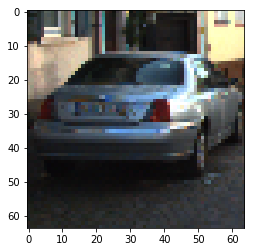

In [113]:
car_image = plt.imread(cars[0])
plt.imshow(car_image)

In [114]:
car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2HLS)


In [117]:
my_car_features,hog_car_image = get_hog_features(car_image[:,:,2], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=True)

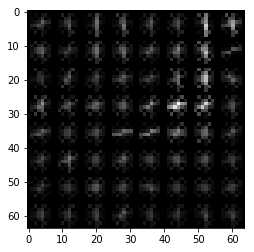

In [118]:
plt.imshow(hog_car_image,cmap='gray')

In [65]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [66]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [67]:
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

347.61 Seconds to train SVC...
Test Accuracy of SVC =  0.9956


In [43]:
image = mpimg.imread('../test1.jpg')
draw_image = np.copy(image)

In [44]:
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

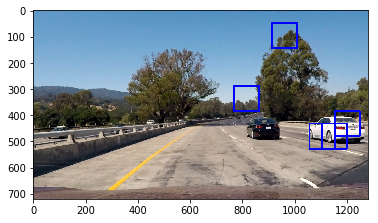

In [45]:
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

In [42]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img_boxes = []
    #img = img.astype(np.float32)/255
    #print ('orient','pix_per_cell',' cell_per_block', 'spatial_size', 'hist_bins', orient, pix_per_cell,
    #    cell_per_block, spatial_size, hist_bins)
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2LUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            #subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            # Scale features and make a prediction
            test_features = X_scaler.transform(stacked)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                img_box = [(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)]
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                cv2.rectangle(draw_img,img_box[0],img_box[1],(0,0,255),6)
                img_boxes.append(img_box)              
    return draw_img,img_boxes

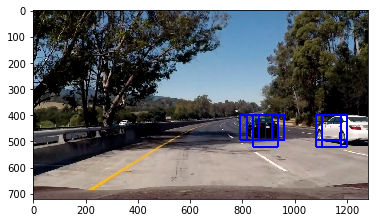

In [121]:
ystart = 400
ystop = 656
scale = 1.5
image = mpimg.imread('../test5.jpg')
draw_image = np.copy(image)
    
out_img,bounded_box = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

In [ ]:
boxes_images = draw_boxes(image, bounded_box)
plt.imshow(boxes_images)

In [18]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [19]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

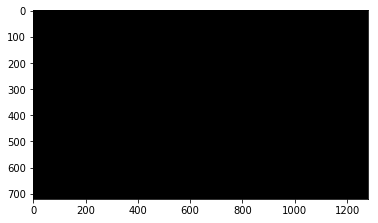

In [20]:
image_heatmap = np.zeros_like(out_img)
plt.imshow(image_heatmap)

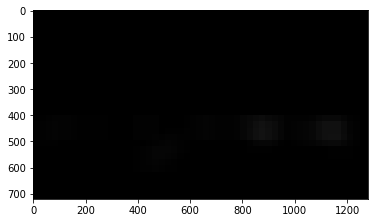

In [120]:
image_heatmap = add_heat(image_heatmap,bounded_box)
plt.imshow(image_heatmap,cmap='hot')

In [73]:
bounded_box

[[(792, 400), (888, 496)],
 [(816, 400), (912, 496)],
 [(840, 400), (936, 496)],
 [(864, 400), (960, 496)],
 [(1032, 400), (1128, 496)],
 [(1056, 400), (1152, 496)],
 [(1056, 424), (1152, 520)],
 [(1080, 424), (1176, 520)],
 [(1104, 400), (1200, 496)],
 [(1128, 400), (1224, 496)],
 [(1128, 424), (1224, 520)],
 [(1152, 400), (1248, 496)],
 [(1152, 424), (1248, 520)]]

In [24]:
from scipy.ndimage.measurements import label
labels = label(image_heatmap)

In [25]:
print(labels[1], 'cars found')
labels[0].shape

2 cars found


(720, 1280, 3)

In [85]:
for i in range(1,3):
    print (i)

1
2


In [26]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [27]:
draw_img = draw_labeled_bboxes(np.copy(image), labels)

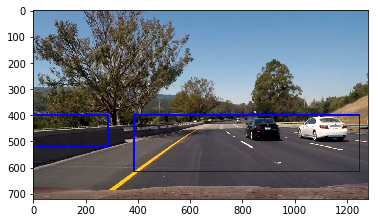

In [28]:
plt.imshow(draw_img)

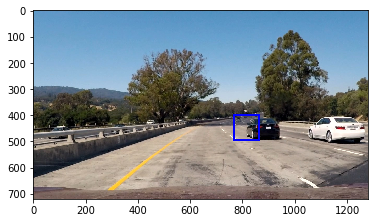

In [57]:
image = mpimg.imread('../test1.jpg')
draw_img = process_image(image)
plt.imshow(draw_img)

In [31]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

In [79]:
white_output = '../white.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../white.mp4
[MoviePy] Writing video ../white.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:01<39:27,  1.88s/it]

  0%|          | 2/1261 [00:02<32:13,  1.54s/it]

  0%|          | 3/1261 [00:03<27:11,  1.30s/it]

  0%|          | 4/1261 [00:04<24:05,  1.15s/it]

  0%|          | 5/1261 [00:04<21:36,  1.03s/it]

  0%|          | 6/1261 [00:05<19:55,  1.05it/s]

  1%|          | 7/1261 [00:06<18:27,  1.13it/s]

  1%|          | 8/1261 [00:07<17:20,  1.20it/s]

  1%|          | 9/1261 [00:07<16:32,  1.26it/s]

  1%|          | 10/1261 [00:08<16:04,  1.30it/s]

  1%|          | 11/1261 [00:09<15:39,  1.33it/s]

  1%|          | 12/1261 [00:09<15:22,  1.35it/s]

  1%|          | 13/1261 [00:10<15:14,  1.37it/s]

  1%|          | 14/1261 [00:11<15:06,  1.38it/s]

  1%|          | 15/1261 [00:12<14:58,  1.39it/s]

  1%|▏         | 16/1261 [00:12<14:55,  1.39it/s]

  1%|▏         | 17/1261 [00:13<14:51,  1.39it/s]

  1%|▏         | 18/1261 [00:14<14:52,  1.39it/s]

  2%|▏         | 19/1261 [00:14<14:50,  1.39it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: ../white.mp4 

CPU times: user 16min 28s, sys: 5.57 s, total: 16min 34s
Wall time: 16min 3s


In [76]:
from collections import deque
iteration = 1

# keep current heatmaps
heatmaps = deque(maxlen=10)
def process_image(image):
    global ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins
    global iteration, heatmaps
    out_img,bounded_box = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    image_heatmap = np.zeros_like(out_img)
    image_heatmap = add_heat(image_heatmap,bounded_box)
    nnzero = np.nonzero(image_heatmap)
    #for i in range(len(nnzero[0])):
        #print(image_heatmap[nnzero[0][i]][nnzero[1][i]][nnzero[2][i]])
    
    #plt.imshow(image_heatmap,cmap='gray')
    heatmaps.append(image_heatmap)
    #heatmaps.append(image_heatmap)
   
   
    
    iteration=iteration+1
    #print(len(heatmaps))
    #if(len(heatmaps) == 10):
    avg_heat = sum(heatmaps)#/len(heatmaps)
        #nnzero = np.nonzero(image_heatmap)
        #for i in range(len(nnzero[0])):
        #    print(avg_heat[nnzero[0][i]][nnzero[1][i]][nnzero[2][i]])
    image_heatmap = avg_heat
    if(len(heatmaps) == 10):
        image_heatmap = apply_threshold(image_heatmap,0.9*len(heatmaps))
    else:
        image_heatmap = apply_threshold(image_heatmap,1.0*len(heatmaps))
    heatmap = np.clip(image_heatmap, 0, 255)
    labels = label(heatmap)
    #print(labels[1])
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

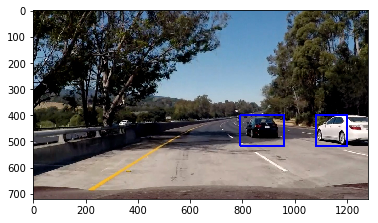

In [78]:
image = mpimg.imread('../test5.jpg')
draw_img = process_image(image)
plt.imshow(draw_img)

In [154]:
x = np.eye(3)

In [171]:
y = np.nonzero(x)
y

(array([0, 1, 2]), array([0, 1, 2]))

In [174]:
len(y[0])

3